In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
import statsmodels.api as sm
import glob
from pathlib import Path
import json
import os
from statsmodels.nonparametric.kernel_regression import KernelReg

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

In [96]:
def get_datadir_from_config(config_file='config.json'):

    config_path = Path(config_file)
    if not config_path.exists():
        raise FileNotFoundError("Missing config.json. Please create one with your local data path.")

    with open(config_path, 'r') as f: 
        config = json.load(f)

    datadir = Path(config['data_path'])
    return datadir
def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files
def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
def get_neuron_profile(file_path):
    """
    Extracts neuron tuning profiles from a single HDF5 session file.

    Parameters:
    - file_path: str, path to the .h5 file

    Returns:
    - neuron_profile: pd.DataFrame with tuning betas, p-values, and metadata
    """
    # Load firing rates and metadata
    fr_CdN = pull_from_h5(file_path, 'CdN_zFR')
    fr_OFC = pull_from_h5(file_path, 'OFC_zFR')
    firing_rates = np.concatenate([fr_CdN, fr_OFC], axis=2)

    u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'),
                              pull_from_h5(file_path, 'OFC_u_names')], axis=0)

    n_CdN = fr_CdN.shape[2]
    n_OFC = fr_OFC.shape[2]
    brain_areas = np.concatenate([np.zeros(n_CdN), np.ones(n_OFC)]).astype(int)

    u_locations = np.concatenate([pull_from_h5(file_path, 'CdN_locations'),
                                  pull_from_h5(file_path, 'OFC_locations')], axis=0)

    bhv = pd.read_hdf(file_path, key='bhv')
    if len(bhv) > len(firing_rates):
        bhv = bhv.iloc[:len(firing_rates)]

    # Trial selection
    trials2keep = bhv['n_sacc'] > 0
    bhv = bhv.loc[trials2keep]
    firing_rates = firing_rates[trials2keep, :, :]
    firing_rates = np.nan_to_num(firing_rates, nan=0)

    # Best-choice trials
    mask = (bhv['n_sacc'] == 1) & (bhv['picked_best'] == 1)
    trial_profile = bhv[mask].reset_index()
    firing_single_best = firing_rates[mask.values, :, :]

    mean_FR = firing_single_best.mean(axis=1)  # shape: (n_trials, n_units)
    n_units = mean_FR.shape[1]

    # GLM design matrix
    df = pd.DataFrame({
        'value': trial_profile['ch_val'].values,
        'state': trial_profile['state'].values
    })
    state_dummies = pd.get_dummies(df['state'].astype(int), prefix='state')
    df = pd.concat([df, state_dummies], axis=1)

    df['state_value_1'] = df['value'] * df['state_1']
    df['state_value_2'] = df['value'] * df['state_2']
    df['state_value_3'] = df['value'] * df['state_3']

    tuning_cols = ['value', 'state_1', 'state_2', 'state_3',
                   'state_value_1', 'state_value_2', 'state_value_3']
    X = df[tuning_cols].astype(int)
    X = sm.add_constant(X)

    # Fit GLM for each neuron
    beta_dict = {col: [] for col in X.columns}
    pval_dict = {col: [] for col in X.columns}

    for i in range(n_units):
        y = mean_FR[:, i]
        model = sm.OLS(y, X).fit()
        for col in X.columns:
            beta_dict[col].append(model.params[col])
            pval_dict[col].append(model.pvalues[col])

    # Assemble neuron profile
    neuron_profile = pd.DataFrame({
        'neuron': u_names,
        'brain_area': brain_areas,
        'lateral': u_locations[:, 0],
        'depth': u_locations[:, 1],
        **{f'{col}_beta': beta_dict[col] for col in X.columns},
        **{f'{col}_pval': pval_dict[col] for col in X.columns}
    })

    return neuron_profile
def get_coding_type(neuron_profile, p_thresh=0.05):
    """Classify neurons based on their coding type using p-value thresholds.
    
    Parameters:
    neuron_profile (pd.DataFrame): DataFrame containing neuron profiles with p-values.
    p_thresh (float): Significance threshold for p-values.
    Returns:
    
    pd.DataFrame: Updated DataFrame with a new 'coding_type' column.
    """
    
    # State coding: any state term is significant
    state_coding = (
        (neuron_profile['state_1_pval'] < p_thresh) |
        (neuron_profile['state_2_pval'] < p_thresh) |
        (neuron_profile['state_3_pval'] < p_thresh)
    )

    # Value coding: value term is significant, but not state coding
    val_coding = (neuron_profile['value_pval'] < p_thresh) & (~state_coding)

    # state_value coding: any interaction term is significant, but not pure value coding
    state_val_coding = (
        (neuron_profile['state_value_1_pval'] < p_thresh) |
        (neuron_profile['state_value_2_pval'] < p_thresh) |
        (neuron_profile['state_value_3_pval'] < p_thresh)
    ) & (~val_coding)

    # Refine state coding: exclude neurons already classified as state_val_coding
    state_coding = state_coding & (~state_val_coding)
    
    neuron_profile['coding_type'] = 'none'  # default
    neuron_profile.loc[state_coding, 'coding_type'] = 'state'
    neuron_profile.loc[val_coding, 'coding_type'] = 'value'
    neuron_profile.loc[state_val_coding, 'coding_type'] = 'state_value'
    
    return neuron_profile
def get_value_correlation(row):
    """
    Determine the value correlation of a neuron based on its coding type and beta coefficients.
    
    Parameters:
    row (pd.Series): A row from the neuron_profile DataFrame.
    only_significant (bool): If True, only consider the primary coding type for correlation.
    
    Returns:
    int or str: 1 for positive correlation, -1 for negative correlation, 'none' if no significant coding.
    """
    if row['coding_type'] == 'value':
        return np.sign(row['value_beta'])
    
    elif row['coding_type'] == 'state':
        state_betas = [row['state_1_beta'], row['state_2_beta'], row['state_3_beta']]
        max_idx = np.argmax(np.abs(state_betas))
        return np.sign(state_betas[max_idx])
    
    elif row['coding_type'] == 'state_value':
        val_state_betas = [row['state_value_1_beta'], row['state_value_2_beta'], row['state_value_3_beta']]
        max_idx = np.argmax(np.abs(val_state_betas))
        return np.sign(val_state_betas[max_idx])
    
    else:
            return 'none'
def gaussian_smooth(neuron_profile, sigma=100, ignore_noncoding=False, num_points=1000):
    neuron_profile.sort_values('depth', inplace=True)
    neuron_profile = neuron_profile.reset_index(drop=True)

    if ignore_noncoding:
        coding_mask = neuron_profile['value_correlation'] != 'none'
        neuron_profile = neuron_profile[coding_mask]
    else:
        neuron_profile['value_correlation'] = (
            neuron_profile['value_correlation'].replace('none', 0.0).infer_objects(copy=False)
        )

    x = neuron_profile['depth'].values.astype(float)
    y = neuron_profile['value_correlation'].values.astype(float)

    sigma = sigma  # Bandwidth for Gaussian kernel
    kr = KernelReg(endog=[y], exog=[x], var_type='c', bw=[sigma])

    x_gird = np.linspace(x.min(), x.max(), num_points)
    y_smoothed, _ = kr.fit(x_gird)
    return x_gird, y_smoothed
def get_null_CI(neuron_profile, n_shuffles=100, sigma=100, num_points=1000):
    null_distributions = []
    for _ in range(n_shuffles):
        shuffled_profile = neuron_profile.copy()
        shuffled_profile['value_correlation'] = np.random.permutation(neuron_profile['value_correlation'])
        x_grid, smoothed_bootstrap = gaussian_smooth(shuffled_profile, sigma=sigma, ignore_noncoding=False, num_points=num_points)
        null_distributions.append(smoothed_bootstrap)
        
    null_distributions = np.array(null_distributions)
    null_CI = np.percentile(null_distributions, [5, 95], axis=0)
    
    return x_grid, null_CI
def get_cluster_profile(x_grid, gaussian_curve, lower_CI, upper_CI):
    def find_clusters(x_grid, mask):
        # Pad mask on head and tail to detect edge clusters
        padded = np.pad(mask.astype(int), (1, 1), constant_values=0)
        transitions = np.diff(padded)
        
        # Find start and end indices of clusters
        starts = np.where(transitions == 1)[0]
        ends = np.where(transitions == -1)[0] - 1
        
        # Return list of (start_depth, end_depth)
        return [(x_grid[start], x_grid[end]) for start, end in zip(starts, ends)]

    # Identify significant regions
    pos_mask = (gaussian_curve > upper_CI)
    neg_mask = (gaussian_curve < lower_CI)
    
    # Extract clusters
    pos_clusters = find_clusters(x_grid, pos_mask)
    neg_clusters = find_clusters(x_grid, neg_mask)
    
    clusters_dict = {
        1: pos_clusters, 
        -1: neg_clusters
    }
    
    cluster_profile = []
    
    for value_correlation, cluster_data in clusters_dict.items():
        for start_depth, end_depth in cluster_data:
            cluster_profile.append({
                'value_correlation': value_correlation,
                'start_depth': start_depth,
                'end_depth': end_depth,
            })
    
    return pd.DataFrame(cluster_profile)
def get_null_cluster_profile(session_profile, x_grid, lower_CI, upper_CI, n_shuffles=100, num_points=1000):
    all_null_clusters_list = []
    
    for _ in range(n_shuffles):
        shuffled_profile = session_profile.copy()
        shuffled_profile['value_correlation'] = np.random.permutation(session_profile['value_correlation'])
        x_grid, gaussian_curve = gaussian_smooth(shuffled_profile, sigma=100, ignore_noncoding=False, num_points=num_points)
        null_clusters = get_cluster_profile(
            x_grid=x_grid,
            gaussian_curve=gaussian_curve,
            lower_CI=lower_CI,
            upper_CI=upper_CI
        )
        all_null_clusters_list.append(null_clusters)
        
    all_null_clusters = pd.concat(all_null_clusters_list)
    
    return all_null_clusters


In [97]:
data_dir = get_datadir_from_config()
data_files = find_h5_files(data_dir)

In [98]:
all_profiles = []

for f in data_files:
    neuron_profile = get_neuron_profile(f)
    neuron_profile['session'] = os.path.basename(f)
    neuron_profile['animal'] = neuron_profile['session'].str[0]
    all_profiles.append(neuron_profile)

all_profiles = pd.concat(all_profiles, ignore_index=True)
all_profiles = get_coding_type(all_profiles, p_thresh=0.05)
all_profiles['value_correlation'] = all_profiles.apply(get_value_correlation, axis=1)
all_profiles.replace({'value_correlation': {'none': 0}}, inplace=True)

C:\Users\krgyk\AppData\Local\Temp\ipykernel_28420\3674662175.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_profiles.replace({'value_correlation': {'none': 0}}, inplace=True)


In [99]:
num_points = 1000
n_shuffles = 1000
brain_area_list = [0, 1]
animal_list = ['D', 'K']
all_clusters = []
all_null_clusters = []

def get_num_units(row, depth_array):
    start, end = row['start_depth'], row['end_depth']
    return np.sum((depth_array >= start) & (depth_array <= end))

for brain_area in brain_area_list:
    for animal in animal_list:
        mask = (all_profiles['brain_area'] == brain_area) & (all_profiles['animal'] == animal)
        neuron_subset = all_profiles[mask]
        
        session_list = neuron_subset['session'].unique()
        
        for s in session_list:
            session_profile = neuron_subset[neuron_subset['session'] == s]
            session_profile = session_profile.sort_values('depth').reset_index(drop=True)
            
            x_grid, gaussian_curve = gaussian_smooth(session_profile, sigma=80, ignore_noncoding=False, num_points=num_points)
            
            x_grid, null_CI = get_null_CI(session_profile, n_shuffles=n_shuffles, sigma=80, num_points=num_points)
            
            if s == 'D20231219_Rec05.h5':  # Plot only for the first session in the loop
                plt.plot(session_profile['depth'], session_profile['value_correlation'], 'o', alpha=0.3, label='Raw Data', color='blue', markersize=4)
                plt.plot(x_grid, gaussian_curve, '-', label='Gaussian Smoothed', color='orange', linewidth=2)
                plt.fill_between(x_grid, 
                        null_CI[0], 
                        null_CI[1],
                        color='gray',
                        alpha=0.3,
                        label='95% CI (shuffled)'
                )
                plt.title(f"Session: {s} | Brain Area: {brain_area}")
                plt.xlabel("Depth")
                plt.ylabel("Value Correlation")
                plt.ylim(-1.2, 1.2)
                plt.legend()
                plt.tight_layout()
                plt.show()
            
            depth_array = session_profile['depth'].values
            
            clusters = get_cluster_profile(
                x_grid, 
                gaussian_curve, 
                null_CI[0], 
                null_CI[1]
            )
            
            clusters['num_units'] = clusters.apply(get_num_units, axis=1, args=(depth_array,))
            clusters['session'] = s
            clusters['brain_area'] = brain_area
            clusters['animal'] = animal
            
            all_clusters.append(clusters)
            
            null_clusters = get_null_cluster_profile(
                session_profile,
                x_grid, 
                null_CI[0], 
                null_CI[1],
                n_shuffles=n_shuffles,
                num_points=num_points
            )
            null_clusters['num_units'] = null_clusters.apply(get_num_units, axis=1, args=(depth_array,))
            null_clusters['session'] = s
            null_clusters['brain_area'] = brain_area
            null_clusters['animal'] = animal
            
            all_null_clusters.append(null_clusters)
            
cluster_profile = pd.concat(all_clusters)
null_cluster_profile = pd.concat(all_null_clusters)

cluster_profile['length'] = cluster_profile['end_depth'] - cluster_profile['start_depth']
num_zero_length = ((cluster_profile["length"] == 0) & (cluster_profile["num_units"] == 0)).sum()
total_clusters = len(cluster_profile) 
print(f"Zero-length clusters with no units: {num_zero_length} out of {total_clusters} total clusters.")
cluster_profile = cluster_profile[(cluster_profile['length'] > 0) & (cluster_profile['num_units'] > 0)]
cluster_profile['density'] = cluster_profile['num_units'] / cluster_profile['length']

null_cluster_profile['length'] = null_cluster_profile['end_depth'] - null_cluster_profile['start_depth']
null_cluster_profile['density'] = null_cluster_profile['num_units'] / null_cluster_profile['length']

KeyboardInterrupt: 

In [ ]:
null_cluster_profile

,value_correlation,start_depth,end_depth,num_units,session,brain_area,animal,length,density
0,1,2740.744918,2836.060753,7,D20231219_Rec05.h5,0,D,95.315835,0.073440
0,1,3419.393662,3514.709496,6,D20231219_Rec05.h5,0,D,95.315835,0.062949
0,1,3743.467500,3804.469634,6,D20231219_Rec05.h5,0,D,61.002134,0.098357
1,-1,3453.707362,3529.960030,5,D20231219_Rec05.h5,0,D,76.252668,0.065571
0,1,1978.218240,2065.908808,10,D20231219_Rec05.h5,0,D,87.690568,0.114037
...,...,...,...,...,...,...,...,...,...
0,1,1876.133254,2076.706128,26,K20240715_Rec09.h5,1,K,200.572874,0.129629
1,-1,1285.767815,1520.400233,42,K20240715_Rec09.h5,1,K,234.632418,0.179003
2,-1,3598.032452,3734.270630,14,K20240715_Rec09.h5,1,K,136.238178,0.102761
0,1,1675.560381,1724.757501,6,K20240715_Rec09.h5,1,K,49.197120,0.121958


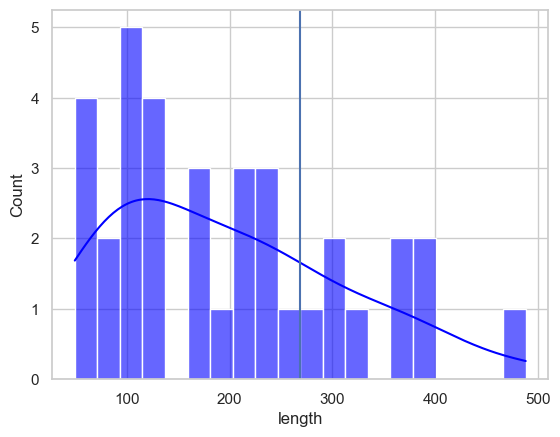

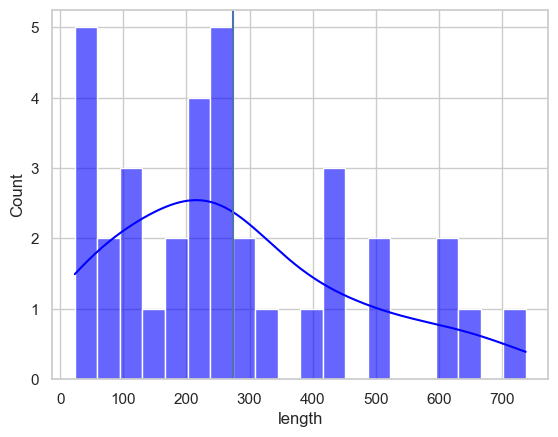

In [ ]:
for brain_area in brain_area_list:
    brain_area_profile = null_cluster_profile[null_cluster_profile['brain_area'] == brain_area]
    
    length_null_CI = np.percentile(brain_area_profile['length'], 95)
    sns.histplot(data=cluster_profile[cluster_profile['brain_area'] == brain_area], x='length', bins=20, color='blue', label='Real clusters', kde=True, alpha=0.6)
    plt.axvline(length_null_CI)
    plt.show()
    
    

In [ ]:
significant_mask = cluster_profile['length'] > length_null_CI
cluster_profile = cluster_profile[significant_mask]

cluster_profile

,value_correlation,start_depth,end_depth,num_units,session,brain_area,animal,length,density
0,1,3.274144,315.910082,44,D20231219_Rec05.h5,0,D,312.635938,0.140739
5,-1,681.922887,1169.939961,87,D20231219_Rec05.h5,0,D,488.017074,0.178272
6,-1,2004.906674,2401.420546,41,D20231219_Rec05.h5,0,D,396.513873,0.103401
2,-1,1600.260515,1963.494058,24,D20231221_Rec06.h5,0,D,363.233543,0.066073
4,-1,712.254606,1007.313780,24,K20240707_Rec06.h5,0,K,295.059174,0.081340
0,1,262.043669,652.672561,45,K20240710_Rec07.h5,0,K,390.628892,0.115199
3,-1,2810.612752,3170.901537,42,K20240710_Rec07.h5,0,K,360.288784,0.116573
1,-1,2243.914369,2518.323948,9,K20240712_Rec08.h5,0,K,274.409579,0.032798
2,-1,1031.006801,1336.521920,14,K20240715_Rec09.h5,0,K,305.515119,0.045824
0,1,971.232620,1381.033439,47,D20231219_Rec05.h5,1,D,409.800819,0.114690


C:\Users\krgyk\AppData\Local\Temp\ipykernel_28420\3958709763.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.pointplot(
C:\Users\krgyk\AppData\Local\Temp\ipykernel_28420\3958709763.py:8: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
C:\Users\krgyk\AppData\Local\Temp\ipykernel_28420\3958709763.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


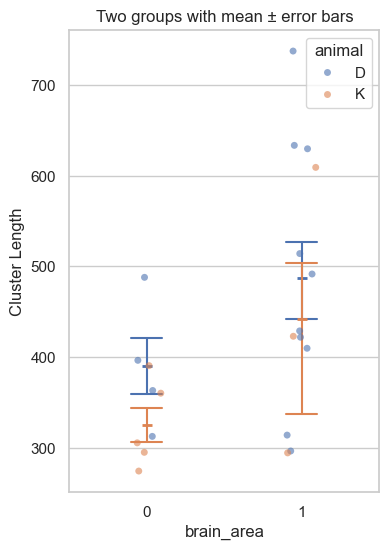

In [ ]:
plt.figure(figsize=(4,6))

sns.stripplot(
    data=cluster_profile, x="brain_area", y="length",
    hue='animal', alpha=0.6, jitter=True
)

sns.pointplot(
    data=cluster_profile, x="brain_area", y="length",
    join=False, capsize=0.2, legend=False, # add error bars
    hue='animal', markers="_", errwidth=1.5,
    ci=68  # for SEM-like (approx 1 SD)
)

plt.ylabel("Cluster Length")
plt.title("Two groups with mean ± error bars")
plt.show()



In [ ]:
from scipy.stats import ttest_ind
result_list =[]
for animal in animal_list:
    animal_clusters = cluster_profile[cluster_profile['animal'] == animal]
    
    OFC_clusters = animal_clusters[animal_clusters['brain_area'] == 1]
    CdN_clusters = animal_clusters[animal_clusters['brain_area'] == 0]
    
    OFC_length = OFC_clusters['length'].values
    CdN_length = CdN_clusters['length'].values
    
    stat, pval = ttest_ind(OFC_length, CdN_length, equal_var=False)
    
    result_list.append({
        'stat': stat,
        'pval': pval,
        'animal': animal,
    })

results = pd.DataFrame(result_list)

results
    

,stat,pval,animal
0,1.670853,0.123604,D
1,1.246525,0.327637,K


In [ ]:
cluster_profile['animal'].nunique()


2

In [ ]:
import pandas as pd
import numpy as np

# Simulate data
np.random.seed(42)
subjects = np.arange(1, 11)  # 10 participants
conditions = ['No', 'Low', 'High']

# Reaction times (in ms)
data = []
for s in subjects:
    no = np.random.normal(300, 20)   # baseline
    low = np.random.normal(280, 20)  # faster
    high = np.random.normal(260, 20) # even faster
    data.append([s, 'No', no])
    data.append([s, 'Low', low])
    data.append([s, 'High', high])

df = pd.DataFrame(data, columns=['subject', 'condition', 'reaction_time'])
print(df.head())

   subject condition  reaction_time
0        1        No     309.934283
1        1       Low     277.234714
2        1      High     272.953771
3        2        No     330.460597
4        2       Low     275.316933


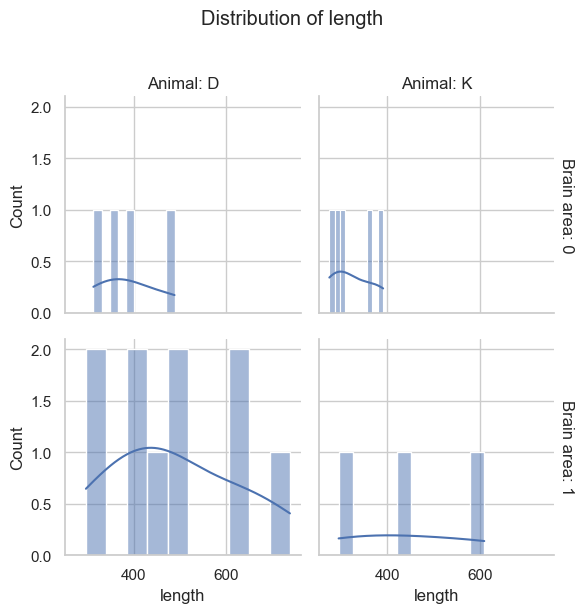

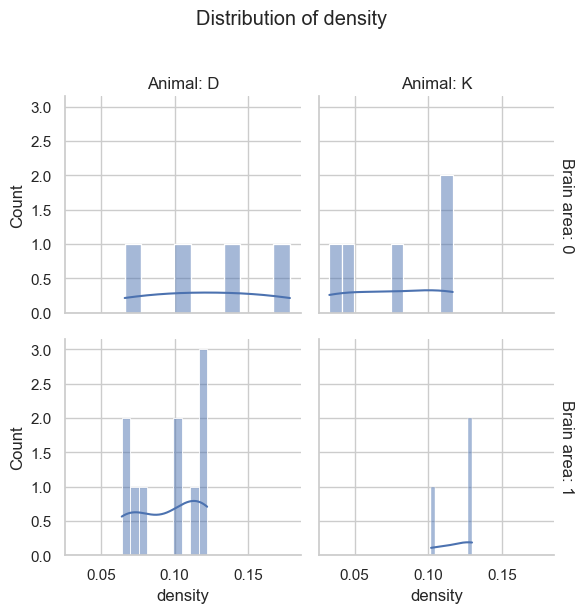

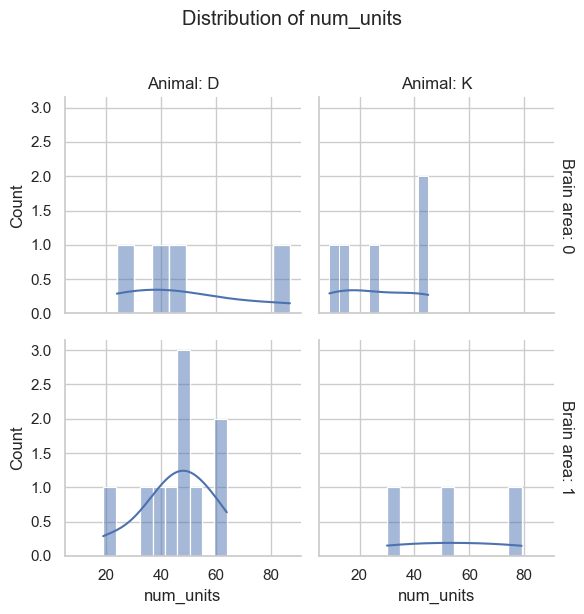

In [ ]:
feature_list = ['length', 'density', 'num_units']
for feature in feature_list:
    g = sns.FacetGrid(cluster_profile, row='brain_area', col='animal', margin_titles=True)
    g.map(sns.histplot, feature, bins=10, kde=True)
    g.set_titles(row_template='Brain area: {row_name}', col_template='Animal: {col_name}')
    plt.suptitle(f'Distribution of {feature}', y=1.02)
    plt.tight_layout()
    plt.show()



In [ ]:
results = []

for animal in animal_list:
    for feature in feature_list:
        animal_clusters = cluster_profile[cluster_profile['animal'] == animal]
        CdN_clusters = animal_clusters[animal_clusters['brain_area'] == 0]
        OFC_clusters = animal_clusters[animal_clusters['brain_area'] == 1]
        
        stat, pval = ttest_ind(CdN_clusters[feature], OFC_clusters[feature], equal_var=False)
        
        results.append({
            'animal': animal,
            'feature': feature,
            't_stat': stat,
            'pval': pval
        })

t_test_df = pd.DataFrame(results)

t_test_df

,animal,feature,t_stat,pval
0,D,length,-1.670853,0.123604
1,D,density,1.051932,0.358159
2,D,num_units,0.242039,0.821900
3,K,length,-1.246525,0.327637
4,K,density,-2.128553,0.080430
5,K,num_units,-1.732201,0.179225



ANOVA for length in animal D:

                                           sum_sq    df         F    PR(>F)
C(value_correlation)                  1514.257348   1.0  0.081947  0.780519
C(brain_area)                        23080.215609   1.0  1.249028  0.289869
C(value_correlation):C(brain_area)   15202.913967   1.0  0.822733  0.385718
Residual                            184785.419386  10.0       NaN       NaN

ANOVA for density in animal D:

                                      sum_sq    df         F    PR(>F)
C(value_correlation)                0.001639   1.0  1.563036  0.239686
C(brain_area)                       0.002812   1.0  2.681131  0.132585
C(value_correlation):C(brain_area)  0.000005   1.0  0.005200  0.943935
Residual                            0.010487  10.0       NaN       NaN

ANOVA for num_units in animal D:

                                         sum_sq    df         F    PR(>F)
C(value_correlation)                 276.923077   1.0  0.862940  0.374797
C(brain_area)    

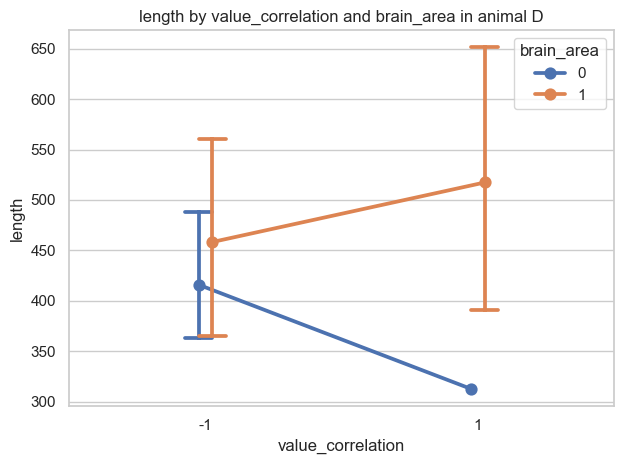

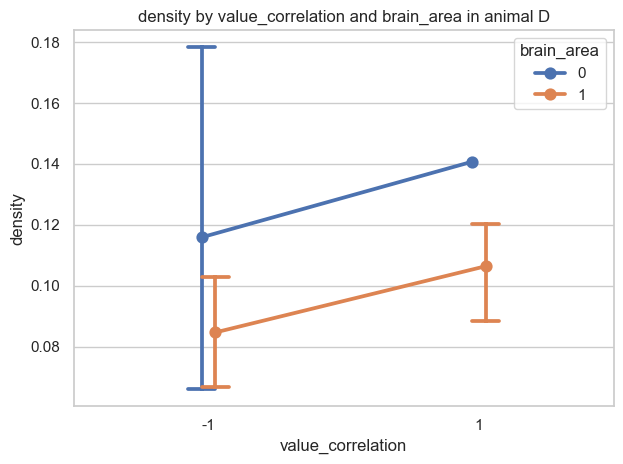

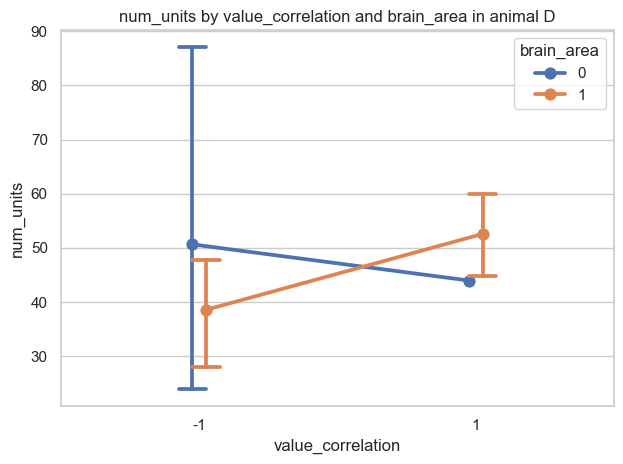


ANOVA for length in animal K:

                                          sum_sq   df         F    PR(>F)
C(value_correlation)                 1456.992442  1.0  0.108744  0.758125
C(brain_area)                       23358.788556  1.0  1.743400  0.257192
C(value_correlation):C(brain_area)   4451.615891  1.0  0.332249  0.595219
Residual                            53593.656017  4.0       NaN       NaN

ANOVA for density in animal K:

                                      sum_sq   df         F    PR(>F)
C(value_correlation)                0.001367  1.0  1.175848  0.339190
C(brain_area)                       0.002553  1.0  2.196309  0.212473
C(value_correlation):C(brain_area)  0.000425  1.0  0.365716  0.577977
Residual                            0.004649  4.0       NaN       NaN

ANOVA for num_units in animal K:

                                         sum_sq   df         F    PR(>F)
C(value_correlation)                 217.648485  1.0  0.473857  0.529062
C(brain_area)                     

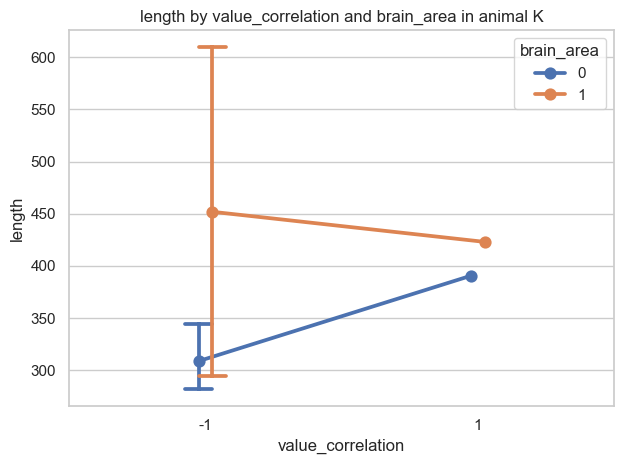

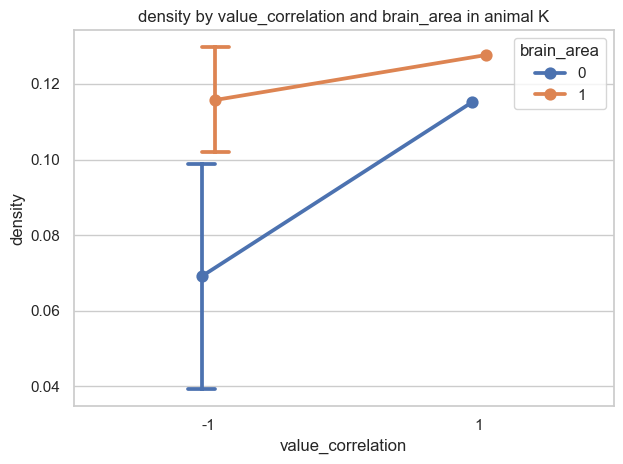

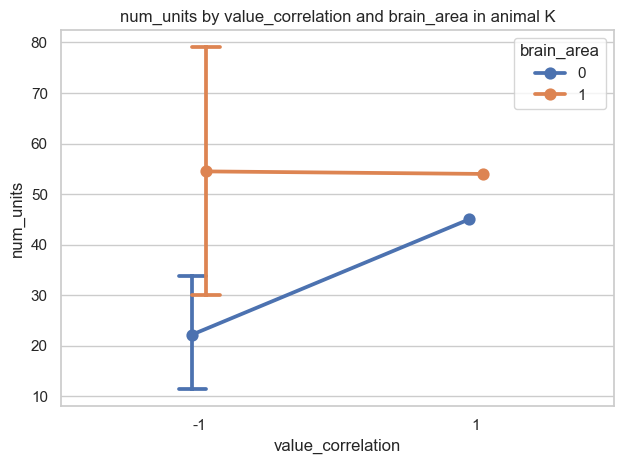

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

features = ['length', 'density', 'num_units']
anova_results = {}

for animal in animal_list:
    animal_clusters = cluster_profile[cluster_profile['animal'] == animal]
    for feature in features:
        formula = f'{feature} ~ C(value_correlation) + C(brain_area) + C(value_correlation):C(brain_area)'
        model = ols(formula, data=animal_clusters).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results[feature] = anova_table
        
    for feature, table in anova_results.items():
        print(f'\nANOVA for {feature} in animal {animal}:\n')
        print(table)


    for feature in features:
        sns.pointplot(data=animal_clusters, x='value_correlation', y=feature, hue='brain_area', dodge=True, markers='o', capsize=.1)
        # sns.stripplot(data=animal_clusters, x='value_correlation', y=feature, hue='brain_area', dodge=False, jitter=False, linewidth=0)
        plt.title(f'{feature} by value_correlation and brain_area in animal {animal}')
        plt.tight_layout()
        plt.show()
